In [10]:
import os
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from osgeo import gdal,osr,ogr

In [3]:
import sys
sys.path.append('../../')

from tsgen import TsGenerator
from nc_explorer import NcExplorer

tsgen = TsGenerator()
exp = NcExplorer()

sen3r-NcExplorer: from mpl_toolkits.basemap import Basemap FAILED!
You can still proceed without plotting any maps.

Declaring class instance from: SEN3R:nc_explorer
Input NetCDF file folder not set. Proceed at your own risk.
initialize set to False, ignoring image geometries. This can be later done manually by calling initialize_geometries() after properly setting the nc_folder.


In [4]:
def nc_dt2num(date):
    # https://stackoverflow.com/questions/39997314/write-times-in-netcdf-file
    units = "hours since 1900-01-01 00:00:00.0"
    calendar = "gregorian"
    return netCDF4.date2num(date, units=units, calendar=calendar)

In [6]:
# set the data directories

# WIN
# shapefile = "D:\\A1_JM\\areas\\previous_areas\\manacapuru.shp"
# ncs = "D:\\git-repos\\cams_visu\\cams_visu\\test_dl\\cams_2019.nc"

# LINUX
ncs = "/d_drive_data/git-repos/cams_visu/cams_visu/test_dl/cams_2019.nc"

In [7]:
ncxp = NcExplorer(verbose=True)

Declaring class instance from: SEN3R:nc_explorer
Verbose set to True.
Input NetCDF file folder not set. Proceed at your own risk.
initialize set to False, ignoring image geometries. This can be later done manually by calling initialize_geometries() after properly setting the nc_folder.


In [8]:
cams_nc = netCDF4.Dataset(ncs,'r')
cams_nc.dimensions

{'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 305,
 'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 249,
 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1460}

In [8]:
# get the longitude information
lons = cams_nc.variables['longitude'][:]
# get the latitude information
lats = cams_nc.variables['latitude'][:]
# extract the time dimension
time = cams_nc.variables['time'][:]

In [10]:
# LINUX
# Sentinel-3 WFR Manacapuru v10
manacaxls = '/d_drive_data/processing/linux/manacapuru_v10.xlsx'
df_s3 = pd.read_excel(manacaxls,sheet_name='manacapuru_v10_noglint')

In [ ]:
# WIN
# Sentinel-3
# madeiraxls = 'D:\\processing\\win\\MADEIRAv9b.xlsx'
# df_s3 = pd.read_excel(madeiraxls,sheet_name='MADEIRAv9b')

In [12]:
# removes hour:minute:seconds from Sentinel-3 data.
df_s3['Date'] = [e.replace(hour=0, minute=0, second=0) for e in df_s3['Datetime']]

# Sort the data by increasing date
df_s3_srtd = df_s3.sort_values(by='Date')

# Get S3 data matching CAMS year 2019
s3_2019 = df_s3_srtd[df_s3_srtd['Date'].dt.year == 2019].copy()

# Create a new column with the same numeric date format as CAMS
s3_2019['dt2num'] = [int(nc_dt2num(d)) for d in s3_2019['Date']]

# Fix the index
s3_2019.reset_index(drop=True, inplace=True)

In [13]:
# Manacapuru Centroid
query_lon, query_lat = -60.8911, -3.5726

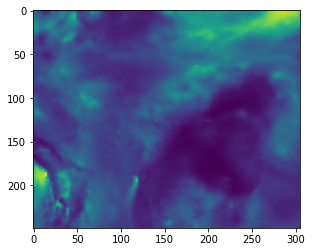

In [14]:
# get the total Aerosol Optical Depth at 865nm 
aod_band = cams_nc.variables['aod865'][120][:]
 
# show the AOD
plt.imshow(aod_band)
plt.show()

In [15]:
lon_grid, lat_grid = np.meshgrid(lons, lats)

In [16]:
exp.get_point_data_in_single_band(aod_band,
                                  lon=lon_grid,
                                  lat=lat_grid, 
                                  target_lon=query_lon,
                                  target_lat=query_lat)[1]

SEN3R:nc_explorer.get_point_data_in_single_band()



0.04124968892540304

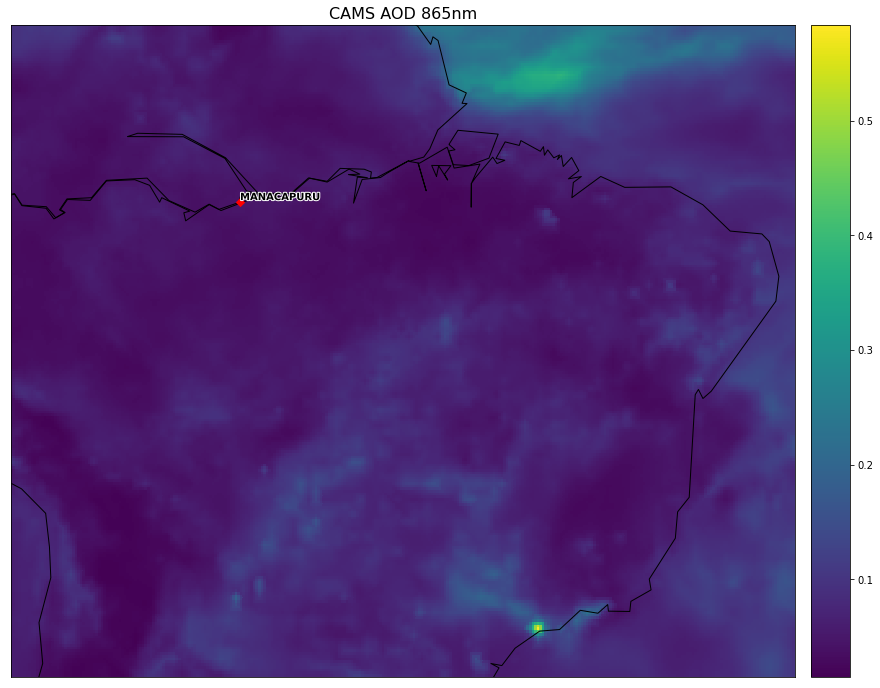

In [177]:
import matplotlib.patheffects as PathEffects
from mpl_toolkits.basemap import Basemap

# Make this plot larger.
plt.figure(figsize=(16,12))

plt.title(f'CAMS AOD 865nm', fontsize=16)

# Miller projection:
m = Basemap(projection='mill',
            lat_ts=10,
            llcrnrlon=lon_grid.min(),
            urcrnrlon=lon_grid.max(),
            llcrnrlat=lat_grid.min(),
            urcrnrlat=lat_grid.max(),
            resolution='c')

m.drawcoastlines()

x, y = m(lon_grid, lat_grid)
plot_var = aod_band
m.pcolormesh(x, y, plot_var, shading='flat') # cmap=plt.cm.gray
m.colorbar(location='right')


xpt, ypt = m(query_lon,query_lat)
m.plot(xpt, ypt, 'rD')
txt = plt.text(xpt, ypt, f'MANACAPURU',fontsize=10,fontweight='bold',
                ha='left',va='bottom',color='k')
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

# plt.savefig('CAMS_manaca.png', bbox_inches='tight')
plt.show()

## Get AOD information over every CAMS day that match S3

In [17]:
# LINUX
ncs = "/d_drive_data/git-repos/cams_visu/cams_visu/test_dl/cams_2019.nc"

# WIN
# ncs = "D:\\git-repos\\cams_visu\\cams_visu\\test_dl\\cams_2019.nc"

cams_nc = netCDF4.Dataset(ncs,'r')
# get the longitude information
lons = cams_nc.variables['longitude'][:]
# get the latitude information
lats = cams_nc.variables['latitude'][:]
# extract the time dimension
time = cams_nc.variables['time'][:]
# convert the 1D lon/lat arrays to 2D
lon_grid, lat_grid = np.meshgrid(lons, lats)

In [18]:
def get_cams_band_by_time(numeric_date, cams_time_array):
    pos = np.where(cams_time_array == numeric_date)[0]
    return pos[0]

In [19]:
# test
get_cams_band_by_time(1043856, time)

120

In [71]:
pos = get_cams_band_by_time(1043856, time)
aod_band = cams_nc.variables['aod865'][120][:]
cams_val = exp.get_point_data_in_single_band(aod_band, lon=lon_grid, lat=lat_grid,
                                             target_lon=query_lon, target_lat=query_lat)[1]
cams_val

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()



0.04124968892540304

In [83]:
def find_cams_val(number_date, cams_time_array):
    # Manacapuru Centroid
    query_lon, query_lat = -60.8911, -3.5726
    # query for the corret day position inside the CAMS time array
    day_position = get_cams_band_by_time(number_date, cams_time_array)
    # extract CAMS AOD data at this day
    aod_band = cams_nc.variables['aod865'][day_position][:]
    # query the AOD pixel value over the target coordinates
    cams_val = exp.get_point_data_in_single_band(aod_band, 
                                                 lon=lon_grid, 
                                                 lat=lat_grid,
                                                 target_lon=query_lon,
                                                 target_lat=query_lat)[1]
    
    return cams_val

In [90]:
aod_values = []

for idx, row in s3_2019.iterrows():
    res = find_cams_val(row['dt2num'], time)
    aod_values.append(res)

s3_2019['cams_aod'] = aod_values

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_band()

S3-FRBR:Nc_Explorer.get_point_data_in_single_b

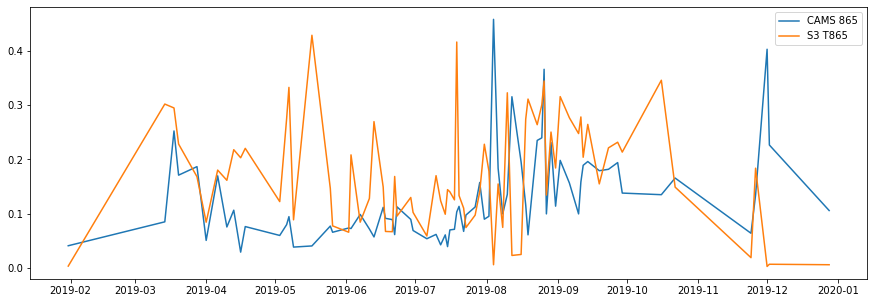

In [175]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(s3_2019['Date'],s3_2019['cams_aod'], label='CAMS 865')
plt.plot(s3_2019['Date'],s3_2019['T865'], label='S3 T865')
plt.legend()
plt.savefig('cams_vs_s3.png', bbox_inches='tight')

Text(0, 0.5, 'S3 AOD 865')

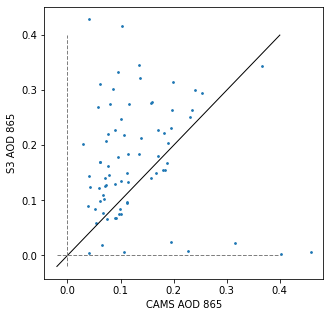

In [181]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(s3_2019['cams_aod'], s3_2019['T865'], s=3)
plt.plot([-0.02, 0.4], [-0.02, 0.4], 'k-', linewidth=1)
plt.plot([0, 0], [-0.02, 0.4], c='grey', linestyle='dashed', linewidth=1)
plt.plot([-0.02, 0.4], [0, 0], c='grey', linestyle='dashed', linewidth=1)
plt.xlabel('CAMS AOD 865')
plt.ylabel('S3 AOD 865')

In [107]:
s3_2019['cams_aod'].corr(s3_2019['T865'])

0.011755028588951048

## Loop through CAMS valid dates

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter 

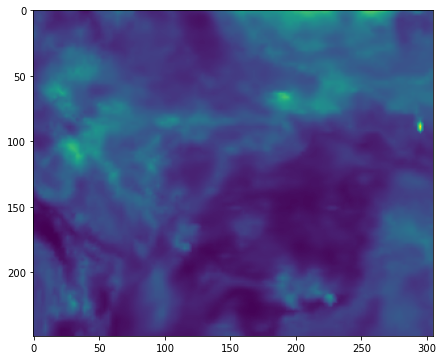

In [136]:
# create a list of images
plt.rcParams['figure.figsize'] = [8, 6]
fig = plt.figure()
ims = []
var_time = cams_nc.variables['time']

for idx, row in s3_2019.iterrows():
    readable_date = str(netCDF4.num2date(row['dt2num'], var_time.units, var_time.calendar))
    day_position = get_cams_band_by_time(row['dt2num'], time)
    aod_band = cams_nc.variables['aod865'][day_position][:]
    frame = plt.imshow(aod_band)
#     im.set_xlabel(readable_date)
    ims.append([frame])


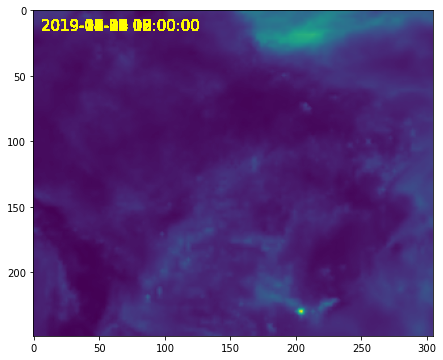

In [173]:
# create a list with all CAMS dates
plt.rcParams['figure.figsize'] = [8, 6]

ims = []
fig = plt.figure("Animation")
ax = fig.add_subplot(111)
var_time = cams_nc.variables['time']
time = cams_nc.variables['time'][:]

for i in range(0,len(time)):
    readable_date = str(netCDF4.num2date(time[i], var_time.units, var_time.calendar))
    aod_band = cams_nc.variables['aod865'][i][:]
    frame = ax.imshow(aod_band)
    t = ax.text(5,15,readable_date,color='yellow',fontsize=15) # add text
    ims.append([frame,t])


In [174]:
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)

    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500)

writer = PillowWriter(fps=11)
# ani.save("demo2.gif", writer=writer)
ani.save('full_cams.gif', writer=LoopingPillowWriter(fps=11)) 

plt.show()

## CAMS as a Proxy

In [1]:
# win
# subset = 'D:\\S3\\L2_WFR_subset\\MANACAPURU\\S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002_subset.txt'
# unix
# subset = '/d_drive_data/S3/L2_WFR_subset/MANACAPURU/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002_subset.txt'

In [18]:
import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

import os
import sys
sys.path.append('../../')

from tsgen import TsGenerator
from nc_explorer import NcExplorer

tsgen = TsGenerator()

def nc_dt2num(date):
    # https://stackoverflow.com/questions/39997314/write-times-in-netcdf-file
    units = "hours since 1900-01-01 00:00:00.0"
    calendar = "gregorian"
    return netCDF4.date2num(date, units=units, calendar=calendar)

def get_cams_band_by_time(numeric_date, cams_time_array):
    pos = np.where(cams_time_array == numeric_date)[0]
    return pos[0]

def find_cams_val(number_date, cams_time_array, query_lon=-60.8911, query_lat=-3.5726):  # Manacapuru Centroid
    # query for the corret day position inside the CAMS time array
    day_position = get_cams_band_by_time(number_date, cams_time_array)
    # extract CAMS AOD data at this day
    aod_band = cams_nc.variables['aod865'][day_position][:]
    # query the AOD pixel value over the target coordinates
    cams_val = ncxp.get_point_data_in_single_band(aod_band, 
                                                 lon=lon_grid, 
                                                 lat=lat_grid,
                                                 target_lon=query_lon,
                                                 target_lat=query_lat)[1]
    
    return cams_val

ncxp = NcExplorer()

Declaring class instance from: SEN3R:nc_explorer
Input NetCDF file folder not set. Proceed at your own risk.
initialize set to False, ignoring image geometries. This can be later done manually by calling initialize_geometries() after properly setting the nc_folder.


In [21]:
# set the data directories

# WIN
# shapefile = "D:\\A1_JM\\areas\\previous_areas\\manacapuru.shp"
# ncs = "D:\\git-repos\\cams_visu\\cams_visu\\test_dl\\cams_2019.nc"

# LINUX
ncs = "/d_drive_data/git-repos/cams_visu/cams_visu/test_dl/cams_2019.nc"

In [22]:
cams_nc = netCDF4.Dataset(ncs,'r')

# get the longitude information
cm_lons = cams_nc.variables['longitude'][:]
# get the latitude information
cm_lats = cams_nc.variables['latitude'][:]
# extract the time dimension
cm_time = cams_nc.variables['time'][:]
# convert the 1D lon/lat arrays to 2D
lon_grid, lat_grid = np.meshgrid(cm_lons, cm_lats)

In [23]:
# LINUX
# Sentinel-3 WFR Manacapuru v10
manaca_xls = '/d_drive_data/processing/linux/manacapuru_v10.xlsx'
df_s3 = pd.read_excel(manaca_xls,sheet_name='manacapuru_v10_noglint')

In [24]:
# WIN
# Sentinel-3
# madeiraxls = 'D:\\processing\\win\\MADEIRAv9b.xlsx'
# df_s3 = pd.read_excel(madeiraxls,sheet_name='MADEIRAv9b')

In [25]:
# removes hour:minute:seconds from Sentinel-3 data.
df_s3['Date'] = [e.replace(hour=0, minute=0, second=0) for e in df_s3['Datetime']]

# Sort the data by increasing date
df_s3_srtd = df_s3.sort_values(by='Date')

# Get S3 data matching year 2019
s3_2019 = df_s3_srtd[df_s3_srtd['Date'].dt.year == 2019].copy()

# Create a new column with the same numeric date format as CAMS
s3_2019['dt2num'] = [int(nc_dt2num(d)) for d in s3_2019['Date']]

# Fix the index
s3_2019.reset_index(drop=True, inplace=True)

In [26]:
aod_values = []

for idx, row in s3_2019.iterrows():
    res = find_cams_val(row['dt2num'], cm_time)
    aod_values.append(res)

s3_2019['cams_aod'] = aod_values

In [30]:
s3_2019.head()

Unnamed: 0                   Datetime      Date-String    B1-400  B2-412.5  \
0         188 2019-01-15 13:46:13.000002  20190115T134613  0.025780  0.028694   
1         189 2019-01-26 14:01:12.000003  20190126T140112  0.028959  0.024539   
2         190 2019-01-27 13:35:01.000001  20190127T133501  0.031571  0.031147   
3         191 2019-01-30 13:57:28.000002  20190130T135728  0.019216  0.018245   
4         192 2019-02-07 13:49:58.999999  20190207T134959  0.038960  0.039300   

   B3-442.5    B4-490    B5-510    B6-560    B7-620  ...  T865.50%tile  \
0  0.044464  0.063615  0.074991  0.107291  0.132977  ...      0.006299   
1  0.024934  0.027638  0.031656  0.044241  0.052944  ...      0.585827   
2  0.043774  0.060374  0.072142  0.102515  0.126249  ...      0.069291   
3  0.025645  0.036614  0.044014  0.065601  0.082291  ...      0.201575   
4  0.050906  0.066056  0.075422  0.103202  0.124145  ...      0.226772   

   T865.75%tile  meanGlint  Glintstd  abs-vld-px  pct-vld-px  \
0      0.069291  67.923914  1.670630        3892    2.749229   
1      0.592126  39.590528  0.018738         350    2.000000   
2      0.075591  88.559502  1.054480        3507    3.592814   
3      0.270866  45.557336  0.053769         428    3.504673   
4      0.300787  59.919016  1.209903        1458    6.858711   

                                            filename  \
0  S3A_OL_2_WFR____20190115T134613_20190115T13491...   
1  S3A_OL_2_WFR____20190126T140112_20190126T14041...   
2  S3A_OL_2_WFR____20190127T133501_20190127T13380...   
3  S3A_OL_2_WFR____20190130T135728_20190130T14002...   
4  S3A_OL_2_WFR____20190207T134959_20190207T13525...   

                        Date   dt2num  cams_aod  
0 2019-01-15 00:00:00.000002  1043472  0.085801  
1 2019-01-26 00:00:00.000003  1043736  0.137592  
2 2019-01-27 00:00:00.000001  1043760  0.082707  
3 2019-01-30 00:00:00.000002  1043832  0.131776  
4 2019-02-07 00:00:00.999999  1044024  0.086049  

[5 rows x 45 columns]

## Save S3:CAMS 2019 DF to excel

In [35]:
path = '/d_drive_data/processing/linux/manaca_cams_v10_2019.xlsx'
# path = f'/d_drive_data/processing/linux/{os.path.basename(out_dir)}.xlsx'
# sheet = f'{os.path.basename(out_dir)}higlint'
sheet = f'v10cams2019'

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book

# LINUX
s3_2019.to_excel(writer, sheet_name=sheet)

# WIN
# series_df.to_excel(f'D:\\processing\\win\\{os.path.basename(out_dir)}.xlsx', sheet_name=f'{os.path.basename(out_dir)}')

writer.save()
writer.close()

## Dynamically find in CAMS the matching S3 day and subtract it from all the pixels

In [5]:
# Individual pixel data
in_dir = '/d_drive_data/processing/linux/manacapuru_v10'

In [8]:
todo = tsgen.build_list_from_subset(in_dir)
todo_fullpath = [os.path.join(in_dir,csv) for csv in todo]
print(f'{todo[0]}\n\n{todo_fullpath[0]}')

S3A_OL_2_WFR____20160502T140055_20160502T140255_20171031T025227_0119_003_338______MR1_R_NT_002.csv

/d_drive_data/processing/linux/manacapuru_v10/S3A_OL_2_WFR____20160502T140055_20160502T140255_20171031T025227_0119_003_338______MR1_R_NT_002.csv


## CAMS Extraction over stations

In [6]:
stations = {'AN1': (-60.8663,-2.5871),
            'Negro': (-60.2647,-3.0696),
            'Manacapuru': (-60.604,-3.326),
            'Borba-Mad.': (-59.64,-4.37),
            'Itacoatiara': (-58.45,-3.16),
            'Óbidos': (-55.58,-1.90),
            'Coari': (-63.02,-4.05),
            'Tefé': (-64.88,-3.12),
            'Fonte Boa': (-66.05,-2.48)}

In [11]:
camsfolder = Path('D:/CAMS')
ncs = os.listdir(camsfolder)

cams_files = {}

for nc in ncs:
    file_path = os.path.join(camsfolder,nc)
    cams_nc = netCDF4.Dataset(file_path,'r')
    year = nc.split('.')[0].split('_')[1]
    cams_files[year] = cams_nc

In [72]:
for s in stations:
    qlon, qlat = stations[s]
    print(s, qlon, qlat)
    sdfs = []
    for year in cams_files:
        print(year)
        cams_nc = cams_files[year]
        var_time = cams_nc.variables['time']
        # get the longitude information
        cm_lons = cams_nc.variables['longitude'][:]
        # get the latitude information
        cm_lats = cams_nc.variables['latitude'][:]
        # extract the time dimension
        cm_time = cams_nc.variables['time'][:]
        # convert the 1D lon/lat arrays to 2D
        lon_grid, lat_grid = np.meshgrid(cm_lons, cm_lats)
        
        aod_by_year = {}
        for time in cm_time:
            readable_date = str(netCDF4.num2date(time, var_time.units, var_time.calendar))
            res = find_cams_val(time, cm_time, query_lon=qlon, query_lat=qlat)
            aod_by_year[readable_date] = res
            
        aod_by_year_nonzero = {k: v for k, v in aod_by_year.items() if v > 0}
        df = pd.DataFrame(list(zip(aod_by_year_nonzero.keys(),aod_by_year_nonzero.values())),columns=['Datetime', 'AOD865'])
        sdfs.append(df)
    
    # Once all years where extracted by a given station, concatenate to generate only one DF for that given station
    stationdf = pd.concat(sdfs, ignore_index=True)
    csvpath = camsfolder/(s+'.csv')
    stationdf.to_csv(csvpath, index=False)
    

AN1 -60.8663 -2.5871
2016
2017
2018
2019
2020
Negro -60.2647 -3.0696
2016
2017
2018
2019
2020
Manacapuru -60.604 -3.326
2016
2017
2018
2019
2020
Borba-Mad. -59.64 -4.37
2016
2017
2018
2019
2020
Itacoatiara -58.45 -3.16
2016
2017
2018
2019
2020
Óbidos -55.58 -1.9
2016
2017
2018
2019
2020
Coari -63.02 -4.05
2016
2017
2018
2019
2020
Tefé -64.88 -3.12
2016
2017
2018
2019
2020
Fonte Boa -66.05 -2.48
2016
2017
2018
2019
2020


In [29]:
cams_nc = cams_files['2016']
var_time = cams_nc.variables['time']
# get the longitude information
cm_lons = cams_nc.variables['longitude'][:]
# get the latitude information
cm_lats = cams_nc.variables['latitude'][:]
# extract the time dimension
cm_time = cams_nc.variables['time'][:]
# convert the 1D lon/lat arrays to 2D
lon_grid, lat_grid = np.meshgrid(cm_lons, cm_lats)

In [30]:
aod_2019 = {}

qlon, qlat = stations['AN1']

for time in cm_time:
    readable_date = str(netCDF4.num2date(time, var_time.units, var_time.calendar))
    res = find_cams_val(time, cm_time, query_lon=qlon, query_lat=qlat)
    aod_2019[readable_date] = res

In [36]:
aod_2019_nonzero = {k: v for k, v in aod_2019.items() if v > 0}

In [52]:
AN12019 = pd.DataFrame(list(zip(aod_2019_nonzero.keys(),aod_2019_nonzero.values())),columns=['Datetime', 'AOD865'])

In [60]:
AN12019['Datetime'][0]

'2016-01-01 06:00:00'

In [61]:
stationdf = pd.concat([AN12019,AN12019,AN12019], ignore_index=True)

In [64]:
stationdf.to_csv('D:\\CAMS\\testdf.csv', index=False)

In [73]:
camscsvfolder = Path('D:/A1_JM/artigo_SEN3R/2_mat_met/CAMS')

In [74]:
station2cams = [s for s in os.listdir(camscsvfolder) if s.endswith('.csv')]

In [76]:
cams_station_dict = {}
for s in station2cams:
    sname = s.split('.')[0]
    df = pd.read_csv(camscsvfolder/s)
    cams_station_dict[sname] = df

In [80]:
cams_station_dict['manacapuru']

Datetime    AOD865
0     2016-01-01 06:00:00  0.447001
1     2016-01-01 12:00:00  0.485241
2     2016-01-01 18:00:00  0.290634
3     2016-01-02 06:00:00  0.259656
4     2016-01-02 12:00:00  0.203305
...                   ...       ...
6937  2020-12-30 18:00:00  0.035058
6938  2020-12-31 00:00:00  0.049849
6939  2020-12-31 06:00:00  0.078216
6940  2020-12-31 12:00:00  0.099986
6941  2020-12-31 18:00:00  0.080969

[6942 rows x 2 columns]